### Implementações necessárias

### Processamento

In [1]:
# Importar dados 
import pandas as pd
from os import listdir
import numpy as np
import cv2

imagens = listdir("C:/UFV/Fotos/")
print imagens

imagem = input("Inserir o indice de posicao da imagem a ser processada = ")
imagem = imagens[imagem]
print imagem

caminho = "C:/UFV/Fotos/"+imagem

['1.jpeg', '10.jpeg', '11.jpeg', '12.jpeg', '13.jpeg', '14.jpeg', '15.jpeg', '16.jpeg', '2.jpeg', '3.jpeg', '4.jpeg', '5.jpeg', '6.jpeg', '7.jpeg', '8.jpeg', '9.jpeg', 'Fotos_Facas.rar']
Inserir o indice de posicao da imagem a ser processada = 3
12.jpeg


In [2]:
# Amostragem iterativa
        
def coordenadas(Im, Im_Limiarizada, f = 0):  
    
    I = Im.copy()
    I[np.where(Im_Limiarizada == 0)] = 100
    
    # Coordenada [x,y] quando acionado o botão direito
    XY = list() 

    #função armazenará uma coordenada toda vez que o botão direito for acionado
    def direito_down(evento, x, y, flags, params):
        
    # evento igual a 2 quando acionado botão direito
        if evento == 2:            
            ID_class = input("Class ID = ")
        
            if f == 0:
                XY.append([x, y, ID_class])
            else:          
                x = range(x-f, x+f+1)
                y = range(y-f, y+f+1)
                for i in range(0, len(x)):
                    for j in range(0, len(y)):
                        XY.append([x[i], y[j], ID_class]) 
                        
            I[(y-3):(y+3), (x-3):(x+3), :] = 255
    
    # Chamada toda vez que uma tecla do mouse é acionada
    cv2.namedWindow('True Color Image')    
    cv2.setMouseCallback('True Color Image', direito_down)  
    
    while True: 
        cv2.imshow('True Color Image', I)
        k = cv2.waitKey(10) & 0XFF
        if k == cv2.EVENT_RBUTTONDOWN:
            break 
        elif k == ord("q"):
            break
            cv2.waitKey()
            cv2.destroyAllWindows()
            
    cv2.destroyAllWindows()
    
    amostras = pd.DataFrame(XY, columns = ["x", "y", "Class"])    
    
    return amostras

In [3]:
# Função Discriminante 
def FD (X,Mu,C,P):
    X = np.matrix(X)
    I = np.linalg.inv(C)# Inversa da matriz de covariância
    D = np.linalg.det(C)# Determinante da matriz de covariância
    A = X-Mu
    FD = -0.5*A*I*A.transpose()-0.5*np.log(1+D)+np.log(1+P)
    return FD

In [4]:
sample = cv2.imread(caminho,1)

sample_gray = cv2.cvtColor(sample, cv2.COLOR_BGR2GRAY)

cv2.imshow("sample true color", cv2.resize(sample,(0,0),fx=0.3,fy=0.3))
cv2.imshow("sample", cv2.resize(sample_gray,(0,0),fx=0.3,fy=0.3))
cv2.waitKey()
cv2.destroyAllWindows()

In [5]:
# Limiarizar imagem
from matplotlib import pyplot as plt

plt.hist(sample_gray.ravel(), 255, [0,256])
plt.show()

thresh, sample_limiarizada = cv2.threshold(sample_gray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

print 'Limiar ótimo pelo Otsu = ', thresh

cv2.imshow("sample limiarizada", cv2.resize(sample_limiarizada,(0,0),fx=0.3,fy=0.3))
cv2.imshow("sample gray", cv2.resize(sample_gray,(0,0),fx=0.3,fy=0.3))
cv2.waitKey()
cv2.destroyAllWindows()

Limiar ótimo pelo Otsu =  130.0


In [6]:
# Remover ruídos
sample_blur = cv2.medianBlur(sample_limiarizada, 5)
EE = cv2.getStructuringElement(cv2.MORPH_ELLIPSE , (11,11))

sample_blur = cv2.morphologyEx(sample_blur, cv2.MORPH_OPEN, EE)
sample_blur = cv2.morphologyEx(sample_blur, cv2.MORPH_CLOSE, EE)

cv2.imshow("sample blur", cv2.resize(sample_blur,(0,0),fx=0.3,fy=0.3))
cv2.imshow("Imagem corrigida", cv2.resize(sample_blur,(0,0),fx=0.3,fy=0.3))

cv2.waitKey()
cv2.destroyAllWindows()

In [7]:
# Preenchendo a imagem
sample_blur_inv = cv2.bitwise_not(sample_blur)
EE = cv2.getStructuringElement(cv2.MORPH_ELLIPSE , (11,11))
sample_blur_inv = cv2.morphologyEx(sample_blur_inv,cv2.MORPH_CLOSE,EE)

K_floodfill = sample_blur_inv.copy()
h,w = sample.shape[:2]
mask = np.zeros((h+2,w+2),np.uint8)

cv2.floodFill(K_floodfill,mask,(0,0),255);
K_floodfill_inv = cv2.bitwise_not(K_floodfill)
F = sample_blur_inv|K_floodfill_inv

cv2.imshow('Imagem Final', cv2.resize(F,(0,0),fx=0.3,fy=0.3))

cv2.waitKey(0)
cv2.destroyAllWindows()

Número de objetos identificados = 1


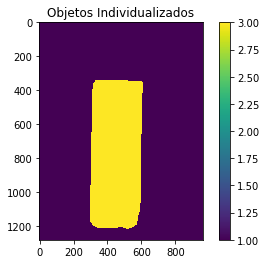

In [8]:
# Quantificar objetos (registrar ID's) para a imagem inteira
sample_contours = F.copy()
objeto, H = cv2.findContours(sample_contours, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
sample_etiquetada = np.zeros((sample.shape[0], sample.shape[1]), np.uint8)

cont = 1
marker = np.zeros((sample.shape[0], sample.shape[1]),dtype = np.int32)

for i in xrange(len(objeto)):
    mask = np.zeros((sample.shape[0], sample.shape[1]), np.uint8)    
    cv2.drawContours(mask, objeto, i, (255,255,255), -1)
    
    sample_etiquetada[np.where(mask != 0)] = cont    
    cont = cont+1
    
    cv2.drawContours(marker,objeto,i,i+2, -1)

marker = marker + 1
marker[objeto==255] = 0
    
print "Número de objetos identificados =", len(np.unique(sample_etiquetada[np.where(sample_etiquetada!= 0)]))

imgplt = plt.imshow(marker)
plt.title('Objetos Individualizados')
plt.colorbar()
plt.show()

In [9]:
# Computar as coordenadas do centro do objeto
sample_cp = sample.copy()
for c in objeto:
    M = cv2.moments(c)
    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])
# draw the contour and center of the shape on the image
    cv2.drawContours(sample_cp, [c], -1, (0, 255, 0), 2)
    cv2.circle(sample_cp, (cX, cY), 7, (255, 255, 255), -1)
    cv2.putText(sample_cp, "center", (cX - 20, cY - 20),
        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
    cv2.imshow("Image", cv2.resize(sample_cp,(0,0),fx=0.6,fy=0.6))
Iy = sample_cp.shape[0] # Dimensões da imagem no eixo y
Ix = sample_cp.shape[1] # Dimensões da imagem no eixo x

print 'A coordenada X do centro é: ',cX
print 'A coordenada Y do centro é: ',cY
print 'As dimensões da imagem são: ',Ix, Iy

cv2.waitKey()
cv2.destroyAllWindows() 

A coordenada X do centro é:  451
A coordenada Y do centro é:  772
As dimensões da imagem são:  960 1280


In [10]:
# Dividir o objeto em quatro quadrantes
Q1 = F[0:cY,0:cX]  # Quadrante superior esquerdo
Q2 = F[0:cY,cX:Ix]  # Quadrante superior direito
Q3 = F[cY:Iy,0:cX]  # Quadrante inferior esquerdo
Q4 = F[cY:Iy,cX:Ix]  # Quadrante inferior direito
Qc1 = sample[0:cY,0:cX]  # Quadrante superior esquerdo
Qc2 = sample[0:cY,cX:Ix]  # Quadrante superior direito
Qc3 = sample[cY:Iy,0:cX]  # Quadrante inferior esquerdo
Qc4 = sample[cY:Iy,cX:Ix]  # Quadrante inferior direito

cv2.imshow('Quadrante superior esquerdo', cv2.resize(Q1,(0,0),fx=0.6,fy=0.6))
cv2.imshow('Quadrante superior direito', cv2.resize(Q2,(0,0),fx=0.6,fy=0.6))
cv2.imshow('Quadrante inferior esquerdo', cv2.resize(Q3,(0,0),fx=0.6,fy=0.6))
cv2.imshow('Quadrante inferior direito', cv2.resize(Q4,(0,0),fx=0.6,fy=0.6))

cv2.waitKey()
cv2.destroyAllWindows() 

Número de objetos identificados em Q1 = 1
Número de objetos identificados em Q2 = 1


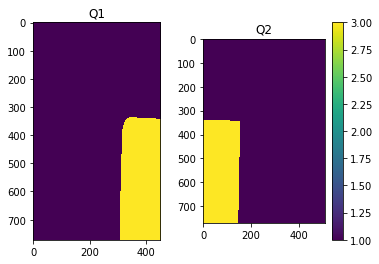

Número de objetos identificados em Q3 = 1
Número de objetos identificados em Q4 = 1


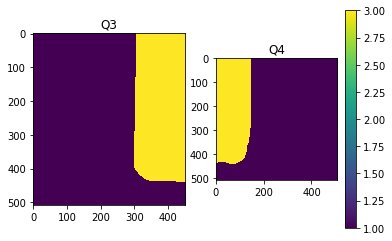

In [11]:
# Quantificar objetos (registrar ID's) para os quadrantes
# Quadrante superior esquerdo
o1, H = cv2.findContours(Q1, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
etiqueta1 = np.zeros((Q1.shape[0], Q1.shape[1]), np.uint8)

cont = 1
marker1 = np.zeros((Q1.shape[0], Q1.shape[1]),dtype = np.int32)

for i in xrange(len(o1)):
    mask = np.zeros((Q1.shape[0], Q1.shape[1]), np.uint8)    
    cv2.drawContours(mask, o1, i, (255,255,255), -1)
    
    etiqueta1[np.where(mask != 0)] = cont    
    cont = cont+1
    
    cv2.drawContours(marker1,o1,i,i+2, -1)

marker1 = marker1 + 1
marker1[o1==255] = 0

print "Número de objetos identificados em Q1 =", len(np.unique(etiqueta1[np.where(etiqueta1!= 0)]))

# Quadrante superior direito
o2, H = cv2.findContours(Q2, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
etiqueta2 = np.zeros((Q2.shape[0], Q2.shape[1]), np.uint8)

cont = 1
marker2 = np.zeros((Q2.shape[0], Q2.shape[1]),dtype = np.int32)

for i in xrange(len(o2)):
    mask = np.zeros((Q2.shape[0], Q2.shape[1]), np.uint8)    
    cv2.drawContours(mask, o2, i, (255,255,255), -1)
    
    etiqueta2[np.where(mask != 0)] = cont    
    cont = cont+1
    
    cv2.drawContours(marker2,o2,i,i+2, -1)

marker2 = marker2 + 1
marker2[o2==255] = 0
    
print "Número de objetos identificados em Q2 =", len(np.unique(etiqueta2[np.where(etiqueta2!= 0)]))

plt.subplot(121), plt.imshow(marker1)
plt.title('Q1')
plt.subplot(122), plt.imshow(marker2)
plt.title('Q2')
plt.colorbar()
plt.show()

# Quadrante inferior esquerdo
o3, H = cv2.findContours(Q3, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
etiqueta3 = np.zeros((Q3.shape[0], Q3.shape[1]), np.uint8)

cont = 1
marker3 = np.zeros((Q3.shape[0], Q3.shape[1]),dtype = np.int32)

for i in xrange(len(o3)):
    mask = np.zeros((Q3.shape[0], Q3.shape[1]), np.uint8)    
    cv2.drawContours(mask, o3, i, (255,255,255), -1)
    
    etiqueta3[np.where(mask != 0)] = cont    
    cont = cont+1
    
    cv2.drawContours(marker3,o3,i,i+2, -1)

marker3 = marker3 + 1
marker3[o3==255] = 0
    
print "Número de objetos identificados em Q3 =", len(np.unique(etiqueta3[np.where(etiqueta3!= 0)]))

# Quadrante inferior direito
o4, H = cv2.findContours(Q4, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
etiqueta4 = np.zeros((Q4.shape[0], Q4.shape[1]), np.uint8)

cont = 1
marker4 = np.zeros((Q4.shape[0], Q4.shape[1]),dtype = np.int32)

for i in xrange(len(o4)):
    mask = np.zeros((Q4.shape[0], Q4.shape[1]), np.uint8)    
    cv2.drawContours(mask, o4, i, (255,255,255), -1)
    
    etiqueta4[np.where(mask != 0)] = cont    
    cont = cont+1
    
    cv2.drawContours(marker4,o4,i,i+2, -1)

marker4 = marker4 + 1
marker4[o4==255] = 0
    
print "Número de objetos identificados em Q4 =", len(np.unique(etiqueta4[np.where(etiqueta4!= 0)]))

plt.subplot(121), plt.imshow(marker3)
plt.title('Q3')
plt.subplot(122), plt.imshow(marker4)
plt.title('Q4')
plt.colorbar()
plt.show()

In [12]:
# Criar dataframe para armazenar descritores de forma
ID = range(0,4)

Descritores_Forma = pd.DataFrame({"ID" : ID, "Perimetro" : 0, "Comprimento" : 0, "Area" : 0, "Retangularidade" : 0})

Descritores_Forma = Descritores_Forma[["ID", "Perimetro", "Comprimento", "Area", "Retangularidade"]]

In [13]:
# Calcular descritores de forma
for i in (np.unique(Descritores_Forma.ID)):        
    if i==0:
        # Criar uma máscara colorida
        m1 = np.zeros((Q1.shape[0], Q1.shape[1], 3), np.uint8)  
        # Desenhar objeto
        cv2.drawContours(m1, o1, (i), (255,255,255), -1)
        #cv2.imshow("objeto %d" %i, mask)
        cv2.waitKey()
        cv2.destroyAllWindows()
    
        # Calcular os inputs dos descritores:
        # Área
        Area1 = cv2.contourArea(o1[i], False)

        # Perímetro
        Perimetro1 = cv2.arcLength(o1[i], False)

        # Mínimo Retângulo Envolvente
        Retangulo_Envolvente1 = cv2.minAreaRect(o1[i])
        E_maior1 = max(Retangulo_Envolvente1[1])
        E_menor1 = min(Retangulo_Envolvente1[1])

        Box1 = cv2.cv.BoxPoints(Retangulo_Envolvente1)
        Box1 = np.int0(Box1)
    
        Mask_Retangulo_Envolvente1 = m1.copy()
        cv2.drawContours(Mask_Retangulo_Envolvente1, [Box1], 0, (255,0,0), 2)  
        
        # Obter os descritores e registrar seus valores
    
        # 0 - Perímetro
        Descritores_Forma.loc[Descritores_Forma["ID"] == (i), "Perimetro"] = Perimetro1
    
        # 1 - Comprimento
        Descritores_Forma.loc[Descritores_Forma["ID"] == (i), "Comprimento"] = E_menor1
    
        # 2 - Área
        Descritores_Forma.loc[Descritores_Forma["ID"] == (i), "Area"] = Area1   
    
        # 3 - Retangularidade = Area/(L1*L2)
        Retangularidade1 = Area1/(E_maior1*E_menor1)
        Descritores_Forma.loc[Descritores_Forma["ID"] == (i), "Retangularidade"] = Retangularidade1

        cv2.waitKey()
        cv2.destroyAllWindows()
        
    elif i==1:
        # Criar uma máscara colorida
        m2 = np.zeros((Q2.shape[0], Q2.shape[1], 3), np.uint8)  
        # Desenhar objeto
        cv2.drawContours(m2, o2, -1, (255,255,255), -1)
        #cv2.imshow("objeto %d" %i, mask)
        cv2.waitKey()
        cv2.destroyAllWindows()
    
        # Calcular os inputs dos descritores:
        # Área
        Area2 = cv2.contourArea(o2[0], False)

        # Perímetro
        Perimetro2 = cv2.arcLength(o2[0], False)

        # Mínimo Retângulo Envolvente
        Retangulo_Envolvente2 = cv2.minAreaRect(o2[0])
        E_maior2 = max(Retangulo_Envolvente2[1])
        E_menor2 = min(Retangulo_Envolvente2[1])

        Box2 = cv2.cv.BoxPoints(Retangulo_Envolvente2)
        Box2 = np.int0(Box2)
    
        Mask_Retangulo_Envolvente2 = m2.copy()
        cv2.drawContours(Mask_Retangulo_Envolvente2, [Box2], 0, (255,0,0), 2)  
        
        # Obter os descritores e registrar seus valores
    
        # 0 - Perímetro
        Descritores_Forma.loc[Descritores_Forma["ID"] == (i), "Perimetro"] = Perimetro2
    
        # 1 - Comprimento
        Descritores_Forma.loc[Descritores_Forma["ID"] == (i), "Comprimento"] = E_menor2
    
        # 2 - Área
        Descritores_Forma.loc[Descritores_Forma["ID"] == (i), "Area"] = Area2   
    
        # 3 - Retangularidade = Area/(L1*L2)
        Retangularidade2 = Area2/(E_maior2*E_menor2)
        Descritores_Forma.loc[Descritores_Forma["ID"] == (i), "Retangularidade"] = Retangularidade2

        cv2.waitKey()
        cv2.destroyAllWindows()
        
    elif i==2:
        # Criar uma máscara colorida
        m3 = np.zeros((Q3.shape[0], Q3.shape[1], 3), np.uint8)  
        # Desenhar objeto
        cv2.drawContours(m3, o3,-1, (255,255,255), -1)
        #cv2.imshow("objeto %d" %i, mask)
        cv2.waitKey()
        cv2.destroyAllWindows()
    
        # Calcular os inputs dos descritores:
        # Área
        Area3 = cv2.contourArea(o3[0], False)

        # Perímetro
        Perimetro3 = cv2.arcLength(o3[0], False)

        # Mínimo Retângulo Envolvente
        Retangulo_Envolvente3 = cv2.minAreaRect(o3[0])
        E_maior3 = max(Retangulo_Envolvente3[1])
        E_menor3 = min(Retangulo_Envolvente3[1])

        Box3 = cv2.cv.BoxPoints(Retangulo_Envolvente3)
        Box3 = np.int0(Box3)
    
        Mask_Retangulo_Envolvente3 = m3.copy()
        cv2.drawContours(Mask_Retangulo_Envolvente3, [Box3], 0, (255,0,0), 2)  
        
        # Obter os descritores e registrar seus valores
    
        # 0 - Perímetro
        Descritores_Forma.loc[Descritores_Forma["ID"] == (i), "Perimetro"] = Perimetro3
    
        # 1 - Comprimento
        Descritores_Forma.loc[Descritores_Forma["ID"] == (i), "Comprimento"] = E_menor3
    
        # 2 - Área
        Descritores_Forma.loc[Descritores_Forma["ID"] == (i), "Area"] = Area3
    
        # 3 - Retangularidade = Area/(L1*L2)
        Retangularidade3 = Area3/(E_maior3*E_menor3)
        Descritores_Forma.loc[Descritores_Forma["ID"] == (i), "Retangularidade"] = Retangularidade3

        cv2.waitKey()
        cv2.destroyAllWindows()
        
    elif i==3:
        # Criar uma máscara colorida
        m4 = np.zeros((Q4.shape[0], Q4.shape[1], 3), np.uint8)  
        # Desenhar objeto
        cv2.drawContours(m4, o4,-1, (255,255,255), -1)
        #cv2.imshow("objeto %d" %i, mask)
        cv2.waitKey()
        cv2.destroyAllWindows()
    
        # Calcular os inputs dos descritores:
        # Área
        Area4 = cv2.contourArea(o4[0], False)

        # Perímetro
        Perimetro4 = cv2.arcLength(o4[0], False)

        # Mínimo Retângulo Envolvente
        Retangulo_Envolvente4 = cv2.minAreaRect(o4[0])
        E_maior4 = max(Retangulo_Envolvente4[1])
        E_menor4 = min(Retangulo_Envolvente4[1])

        Box4 = cv2.cv.BoxPoints(Retangulo_Envolvente4)
        Box4 = np.int0(Box4)
    
        Mask_Retangulo_Envolvente4 = m4.copy()
        cv2.drawContours(Mask_Retangulo_Envolvente4, [Box4], 0, (255,0,0), 2)  
        
        # Obter os descritores e registrar seus valores
    
        # 0 - Perímetro
        Descritores_Forma.loc[Descritores_Forma["ID"] == (i), "Perimetro"] = Perimetro4
    
        # 1 - Comprimento
        Descritores_Forma.loc[Descritores_Forma["ID"] == (i), "Comprimento"] = E_menor4
    
        # 2 - Área
        Descritores_Forma.loc[Descritores_Forma["ID"] == (i), "Area"] = Area4   
    
        # 3 - Retangularidade = Area/(L1*L2)
        Retangularidade4 = Area4/(E_maior4*E_menor4)
        Descritores_Forma.loc[Descritores_Forma["ID"] == (i), "Retangularidade"] = Retangularidade4

        cv2.waitKey()
        cv2.destroyAllWindows()

print Descritores_Forma

   ID    Perimetro  Comprimento     Area  Retangularidade
0   0  1106.254833   143.999969  59688.0         0.959491
1   1  1134.213203   152.999969  63705.5         0.972841
2   2  1006.811182   150.999969  63798.5         0.966835
3   3   997.580734   145.999969  60312.5         0.941001


In [17]:
# Coletar amostras (buffer de amostragem = "f")
# Classe 1 - Faca Boa; Classe 2 - Faca Ruim 
dados_aux1 = coordenadas(cv2.resize(Qc1,(0,0),fx=0.6,fy=0.6), cv2.resize(Q1,(0,0),fx=0.6,fy=0.6))
dados_aux2 = coordenadas(cv2.resize(Qc2,(0,0),fx=0.6,fy=0.6), cv2.resize(Q2,(0,0),fx=0.6,fy=0.6))
dados_aux3 = coordenadas(cv2.resize(Qc3,(0,0),fx=0.6,fy=0.6), cv2.resize(Q3,(0,0),fx=0.6,fy=0.6))
dados_aux4 = coordenadas(cv2.resize(Qc4,(0,0),fx=0.6,fy=0.6), cv2.resize(Q4,(0,0),fx=0.6,fy=0.6))
print dados_aux1
print dados_aux2
print dados_aux3
print dados_aux4

Class ID = 2
Class ID = 1
Class ID = 1
Class ID = 2
     x    y  Class
0  224  268      2
    x    y  Class
0  71  303      1
     x    y  Class
0  203  100      1
    x    y  Class
0  55  121      2


In [23]:
# Integrar dados aos ID's
amostragem1 = np.zeros((cv2.resize(Qc1,(0,0),fx=0.6,fy=0.6).shape[0], cv2.resize(Qc1,(0,0),fx=0.6,fy=0.6).shape[1]), np.uint8)
amostragem1[dados_aux1.y, dados_aux1.x] = 255

amostragem2 = np.zeros((cv2.resize(Qc2,(0,0),fx=0.6,fy=0.6).shape[0], cv2.resize(Qc2,(0,0),fx=0.6,fy=0.6).shape[1]), np.uint8)
amostragem2[dados_aux2.y, dados_aux2.x] = 255

amostragem3 = np.zeros((cv2.resize(Qc3,(0,0),fx=0.6,fy=0.6).shape[0], cv2.resize(Qc3,(0,0),fx=0.6,fy=0.6).shape[1]), np.uint8)
amostragem3[dados_aux3.y, dados_aux3.x] = 255

amostragem4 = np.zeros((cv2.resize(Qc4,(0,0),fx=0.6,fy=0.6).shape[0], cv2.resize(Qc4,(0,0),fx=0.6,fy=0.6).shape[1]), np.uint8)
amostragem4[dados_aux4.y, dados_aux4.x] = 255

cv2.waitKey()
cv2.destroyAllWindows()
print "ID's amostrados = ", np.unique(sample_etiquetada[dados_aux.y, dados_aux.x]), "\n"

# Tornar compatível indices dos dados_aux e repositório
dados_aux1["ID"] = sample_etiquetada[dados_aux1.y, dados_aux1.x]
dados_aux2["ID"] = sample_etiquetada[dados_aux2.y, dados_aux2.x]
dados_aux3["ID"] = sample_etiquetada[dados_aux3.y, dados_aux3.x]
dados_aux4["ID"] = sample_etiquetada[dados_aux4.y, dados_aux4.x]
indices_compativeis1 = dados_aux1.ID-1
indices_compativeis2 = dados_aux2.ID-1
indices_compativeis3 = dados_aux3.ID-1
indices_compativeis4 = dados_aux4.ID-1
dados_aux1 = dados_aux1.set_index(indices_compativeis1)
dados_aux2 = dados_aux2.set_index(indices_compativeis2)
dados_aux3 = dados_aux3.set_index(indices_compativeis3)
dados_aux4 = dados_aux4.set_index(indices_compativeis4)

del dados_aux1.index.name
del dados_aux2.index.name
del dados_aux3.index.name
del dados_aux4.index.name

p = np.append(dados_aux1,
             dados_aux2,
             dados_aux3,
             dados_aux4)

rep = pd.concat([dados_aux1, dados_aux2, dados_aux3, dados_aux4.loc[:,  dados_aux4.columns != "ID"]], axis = 1)

print p 

ID's amostrados =  [0] 



TypeError: append() takes at most 3 arguments (4 given)

In [ ]:
# Exportar dados 

import re
amostra = re.split(r'\.(?!\d)', imagem)[0]
amostra = np.int(amostra)
print amostra

chave = input("Definir amostra como 0 (Faca de referencia) ou 1 (Faca para avaliacao):")

if chave == 0:
    Descritores_Forma.to_excel("C:/UFV/Dados_faca/Ref/dados_%d.xlsx" %amostra, index = False)
else:
    Descritores_Forma.to_excel("C:/UFV/Dados_faca/Ava/dados_%d.xlsx" %amostra, index = False)

In [ ]:
# Importar dados de avaliacao
amostras = listdir("C:/UFV/Dados_faca/Ava/")
avaliacao = pd.DataFrame()

for i in xrange(len(amostras)):
    dados_i = pd.read_excel("C:/UFV/Dados_faca/Ava/"+amostras[i])
    
    avaliacao = avaliacao.append(dados_i, ignore_index = True)

Rang = range(0,56)
Class = pd.DataFrame({"Classe" : 1}, index=Rang)
Class = Class[["Classe"]]
repositorio_ava = pd.concat([Class, avaliacao.loc[:, avaliacao.columns]], axis = 1)

print "Dados de Avaliacao\n"
print repositorio_ava

In [ ]:
# Importar dados de referencia 
amostras = listdir("C:/UFV/Dados_faca/Ref/")
referencia = pd.DataFrame()

for i in xrange(len(amostras)):
    dados_i = pd.read_excel("C:/UFV/Dados_faca/Ref/"+amostras[i])
    
    referencia = referencia.append(dados_i, ignore_index = True)

Class2 = pd.DataFrame({"Classe" : 0}, index = referencia.ID)
Class2 = Class2[["Classe"]]
repositorio_ref = pd.concat([Class2, referencia.loc[:, referencia.columns]], axis = 1)

print "Dados de Referencia\n"
print repositorio_ref

In [ ]:
%% Blade reconstitution (trigonometric approach)

%Houghlines
IH = edge(Igray,'canny',T);
[HI,TI,RI] = hough(IH);
PI = houghpeaks(HI,10,'threshold',10);
lI = houghlines(Igray,TI,RI,PI);% ,'FillGap',20,'MinLength',20)

%Store theta and rho values
for i=1:length(lI)
    tr(i,1) = lI(i).theta;
    if tr(i,1) == 0
        tr(i,1) = 0.0001;
    end
    tr(i,2) = lI(i).rho;
end

%Select only two vertical and two horizontal lines (most colinear points)
cv = 0;
ch = 0;
for i=1:length(tr)
    if tr(i,1) < 10 && tr(i,1) > -10 && cv<2 %criteria vert theta low
        cv = cv+1;
        trn(cv,1) = tr(i,1);
        trn(cv,2) = tr(i,2);
        trn(cv,3) = lI(i).point1(1);
        trn(cv,4) = lI(i).point1(2);
        trn(cv,5) = lI(i).point2(1);
        trn(cv,6) = lI(i).point2(2);
    end
        if tr(i,1) < -70 && ch <2 %criteria hor theta high
        ch = ch+1;
        trn(2+ch,1) = tr(i,1);
        trn(2+ch,2) = tr(i,2);
        trn(2+ch,3) = lI(i).point1(1);
        trn(2+ch,4) = lI(i).point1(2);
        trn(2+ch,5) = lI(i).point2(1);
        trn(2+ch,6) = lI(i).point2(2);
    end
end

%Sorts vector
if trn(1,3)>trn(2,3)
        arm(1,:) = trn(1,:);
        trn(1,:)=trn(2,:);
        trn(2,:)=arm(1,:);
end
    
figure, imshow(If), colormap gray;
hold on

%Plot selected lines over binary image
for i=1:size(trn,1)
    xy = [trn(i,3),trn(i,4); trn(i,5),trn(i,6)]; %store coordinates in xy vector
    plot(xy(:,1),xy(:,2),'--','LineWidth',2,'Color','red'); %plot lines
    hold on
end

% Find intersections between lines(x coordinates)
drti3 = (trn(3,2)/sind(trn(3,1)))-(trn(1,2)/sind(trn(1,1)));
tgi13 = 1/(1/tand(trn(3,1))-1/tand(trn(1,1)));
i13 = drti3*tgi13;

drti4 = (trn(4,2)/sind(trn(4,1)))-(trn(1,2)/sind(trn(1,1)));
tgi14 = 1/(1/tand(trn(4,1))-1/tand(trn(1,1)));
i14 = drti4*tgi14;

drt23 = (trn(2,2)/sind(trn(2,1)))-(trn(3,2)/sind(trn(3,1)));
tgi23 = 1/(1/tand(trn(2,1))-1/tand(trn(3,1)));
i23 = drt23*tgi23;

drt24 = (trn(2,2)/sind(trn(2,1)))-(trn(4,2)/sind(trn(4,1)));
tgi24 = 1/(1/tand(trn(2,1))-1/tand(trn(4,1)));
i24 = drt24*tgi24;

% Find intersections between lines(y coordinates)
y13 = (trn(1,2)-i13*cosd(trn(1,1)))/sind(trn(1,1));
y14 = (trn(1,2)-i14*cosd(trn(1,1)))/sind(trn(1,1));
y23 = (trn(2,2)-i23*cosd(trn(2,1)))/sind(trn(2,1));
y24 = (trn(2,2)-i24*cosd(trn(2,1)))/sind(trn(2,1));

%Stores intersection coordinates in vector
g(1,1) = i13;
g(1,2) = y13;
g(2,1) = i23;
g(2,2) = y23;
g(3,1) = i24;
g(3,2) = y24;
g(4,1) = i14;
g(4,2) = y14;
g(5,1) = i13;
g(5,2) = y13;

vetint(1,1) = i13;
vetint(1,2) = y13;
vetint(2,1) = i23;
vetint(2,2) = y23;
vetint(3,1) = i24;
vetint(3,2) = y24;
vetint(4,1) = i14;
vetint(4,2) = y14;
vetint = sortrows(vetint);

if vetint(1,2)<vetint(2,2)
IE(1,1) = vetint(1,1);
IE(1,2) = vetint(1,2);
IE(2,1) = vetint(2,1);
IE(2,2) = vetint(2,2);
else
IE(1,1) = vetint(2,1);
IE(1,2) = vetint(2,2);
IE(2,1) = vetint(1,1);
IE(2,2) = vetint(1,2);
end

if vetint(3,2)<vetint(4,2)
IE(3,1) = vetint(3,1);
IE(3,2) = vetint(3,2);
IE(4,1) = vetint(4,1);
IE(4,2) = vetint(4,2);
else
IE(3,1) = vetint(4,1);
IE(3,2) = vetint(4,2);
IE(4,1) = vetint(3,1);
IE(4,2) = vetint(3,2);
end

%Plot intersected lines
imshow(If);
hold on
plot(g(:,1),g(:,2),'-','color','k')

close Figure 2
%Fill up the gaps (Blade reconstitution)
x = [IE(1,1) IE(2,1) IE(4,1) IE(3,1)];
y = [IE(1,2) IE(2,2) IE(4,2) IE(3,2)];
patch(x,y,'black')
%Saves reconstitude blade
saveas(gcf,'HR.png')
HR = imread('C:\Users\Guilherme\Dropbox\PRODUÇÕES\ARTIGOS\A publicar\Image Processing\Códigos\HR.png');
HR = im2bw(HR);
imshow(HR);

%% Distance between actual and reconstitude blade (crack detection)

%x y left line equation
a1 = (trn(1,3)-trn(1,5))/(trn(1,4)-trn(1,6));
b1 = trn(1,3)-trn(1,4)*a1;

%Measures distance between houghline and actual blade --> crack detection
y = ceil(IE(1,2))+20;
x = ceil(IE(1,1));
c=1;
for i=1:(IE(2,2)-y)
    dfe(i) = 0;
end

while y < IE(2,2)-30
    while If(y,x)~=0
        dfe(c)=dfe(c)+1;
        x=x+1;
    end
    c=c+1;
    y=y+1;
    x=ceil(a1*y+b1);
end

%x y right line equation
a2 = (trn(2,3)-trn(2,5))/(trn(2,4)-trn(2,6));
b2 = trn(2,3)-a2*trn(2,4);

%Measures distance between houghline and actual blade --> crack detection
y = ceil(IE(3,2))+20;
x = ceil(IE(3,1));

c=1;
for i=1:(IE(4,2)-y)
    dfd(i) = 0;
end

while y < IE(4,2)-20
    while If(y,x)~=0
        dfd(c)=dfd(c)+1;
        x=x-1;
    end
    c=c+1;
    y=y+1;
    x=ceil(a2*y+b2);
end

%% BLADE GEOMETRIC PROPERTIES

stats = regionprops(If,'Area','Centroid','Perimeter','MajorAxisLength','MinorAxisLength');
for i=1:length(stats)
    info(i,1) = stats(i).Centroid(1);
    info(i,2) = stats(i).Centroid(2);
    info(i,3) = stats(i).Area;
    info(i,4) = stats(i).Perimeter;
    info(i,5) = stats(i).MajorAxisLength;
    info(i,6) = stats(i).MinorAxisLength;
end

If = imcomplement(If);
stats = regionprops(If,'Area','Centroid','Perimeter','MajorAxisLength','MinorAxisLength');
for i=1:length(stats)
    info2(i,1) = stats(i).Centroid(1);
    info2(i,2) = stats(i).Centroid(2);
    info2(i,3) = stats(i).Area;
    info2(i,4) = stats(i).Perimeter;
    info2(i,5) = stats(i).MajorAxisLength;
    info2(i,6) = stats(i).MinorAxisLength;
end
great = 0;
for i=1:length(stats)
    if info2(i,3)>great
        great=info2(i,3)
        pos = i
    end
end
info(1,:) = info2(pos,:);
imshow(If)
hold on
plot(info(:,1),info(:,2),'rx');

%% Divide imagem
close Figure 1
%Superior left corner
for i=1:ceil(info(1,2))
    for j=1:ceil(info(1,1))
        SUPLEFT(i,j) = If(i,j);
    end
end

imshow(SUPLEFT)

%Superior right corner
for i=1:ceil(info(1,2))
    for j=ceil(info(1,1)):size(If,2)
        SUPRIGHT(i,j) = If(i,j);
    end
end
%imshow(SUPRIGHT)

%Inferior left corner
for i=1:ceil(info(1,2))
    for j=ceil(info(1,1)):size(If,1)-1
        INFLEFT(i,j) = If(i,j);
    end
end
imshow(INFLEFT)
break
for i=1:info(1,2)
    for j=1:info(1,1)
        SUPRIGTH(i,j) = If(i,j);
    end
end
imshow(SUPRIGTH);

%% Extra

% [centers, radii] = imfindcircles(If,[23 32],'ObjectPolarity','bright','Sensitivity',0.93);
% figure, imshow(If)
% viscircles(centers, radii,'EdgeColor','r');
% hold on
% for i=1:size(centers,1)
%     txt{i} = num2str(i);
%     plot(centers(i,1),centers(i,2),'x');
%     text(centers(i,1),centers(i,2),txt{i},'color','r');
% end

In [ ]:
# Calcular probabilidade de cada classe
treinamento_length = treinamento.shape[0]
Probabilidades = list()

for i in np.unique(treinamento.Class):
    class_i = treinamento.loc[treinamento["Class"] == i,"Class"]
    class_i = len(class_i)
    
    prob_i = class_i/float(treinamento_length)
    
    Probabilidades.insert(i, prob_i)
    
#Probabilidades = [0.33, 0.33, 0.33]
print Probabilidades

In [ ]:
# Separar conjunto de treinamento para cada defeito
treinamento_classe = list()

for i in np.unique(treinamento.Class):    
    treinamento_classe_i = treinamento.loc[treinamento["Class"] == i, :] 
    treinamento_classe_i = treinamento_classe_i.iloc[:,treinamento_classe_i.columns != "ID"]
    
    treinamento_classe.insert(i, treinamento_classe_i)    
    
print treinamento_classe

In [ ]:
# Gerar matrizes de covariancia e vetores medios com dados de treinamento
# Classes: normais, quebrados, pretos + verdes, cascas
Cov_Matrix = list()
Vetor_Medio = list()

for i in xrange(len(treinamento_classe)):
    treinamento_classe_i = treinamento_classe[i]     
    treinamento_classe_i = pd.DataFrame(treinamento_classe_i)
    treinamento_classe_i = treinamento_classe_i.loc[:, treinamento_classe_i.columns != "Class"]
    treinamento_classe_i = treinamento_classe_i.T
    #print treinamento_classe_i, "\n"  
    
    treinamento_classe_i = treinamento_classe_i.as_matrix()
    #print treinamento_classe_i, "\n"
        
    Cov_Matrix_i = np.cov(treinamento_classe_i)
    #print Cov_Matrix_i, "\n"
    Cov_Matrix.insert(i, Cov_Matrix_i)
    
    Vetor_Medio_i = np.average(treinamento_classe_i,1)# Vetor médio
    #print Vetor_Medio_i, "\n"
    
    Vetor_Medio.insert(i, Vetor_Medio_i)

#print Cov_Matrix[0], "\n"
#print Vetor_Medio[0], "\n"

In [ ]:
# Importar dados de validacao
amostras = listdir("C:/UFV/2 Semestre/ENG 639/Trabalho/Dados/Validacao/")
validacao = pd.DataFrame()

for i in xrange(len(amostras)):
    validacao_i = pd.read_excel("C:/UFV/2 Semestre/ENG 639/Trabalho/Dados/Validacao/"+amostras[i])
    
    validacao = validacao.append(validacao_i, ignore_index = True)
    
print validacao

In [ ]:
# Separar conjunto de validacao para cada defeito
validacao_classe = list()
ID = list()

for i in np.unique(validacao.Class):    
    validacao_classe_i = validacao.loc[validacao["Class"] == i, :] 
    validacao_classe_i = validacao_classe_i.reset_index(drop=True)
    #print validacao_classe_i
    
    ID_i = validacao_classe_i.loc[:,"ID"]
    ID.insert(i, ID_i)
    
    validacao_classe_i = validacao_classe_i.iloc[:,validacao_classe_i.columns != "ID"]    
    validacao_classe.insert(i, validacao_classe_i)
       
#print validacao_classe
#print ID

In [ ]:
# Processar matriz de validacao para adequar a FD
Matrix_Validacao = list()

for i in xrange(len(validacao_classe)):
    validacao_classe_i = validacao_classe[i]     
    validacao_classe_i = pd.DataFrame(validacao_classe_i)
    validacao_classe_i = validacao_classe_i.loc[:, validacao_classe_i.columns != "Class"]
    validacao_classe_i = validacao_classe_i.T
    #print validacao_classe_i, "\n"  
    
    validacao_classe_i = validacao_classe_i.as_matrix()
    #print matrix_classe_i, "\n"    
    
    Matrix_Validacao.insert(i, validacao_classe_i)
    
#print Matrix_Validacao

In [ ]:
# Criar um repositório para resultado da classificacao
Classificacao = pd.DataFrame({"Class" : validacao.Class, "ID" : validacao.ID})

for i in np.unique(validacao.Class):
    class_i = [0]*len(validacao.Class)
    Classificacao_i = pd.DataFrame({"%d" %i : class_i})
    
    Classificacao = pd.concat([Classificacao, Classificacao_i], axis=1)

print Classificacao

In [ ]:
# Aplicar classificar nas imagens de validacao   
for i in xrange(len(Matrix_Validacao)): # i define a matriz de validacao das classes
    
    Matrix_Validacao_i = Matrix_Validacao[i]
    
    for j in xrange(len(Vetor_Medio)): # j define as classes de defeitos
        
        Vetor_Medio_j = Vetor_Medio[j]        
        Cov_Matrix_j = Cov_Matrix[j]
        Probabilidades_j = Probabilidades[j]    
        
        for k in range(0,Matrix_Validacao_i.shape[1]): # k define o objeto que está sendo classificado na matriz i
            FD_ij = FD(Matrix_Validacao_i[:,k], Vetor_Medio_j, Cov_Matrix_j, Probabilidades_j)  
            
            ID_i = ID[i][k]
            
            coluna = str(j+1)           
            
            Classificacao.loc[Classificacao["ID"] == ID_i, Classificacao.columns == coluna] = FD_ij
            
            #if k == 0:
                #print "ID = ", ID_i 
                #print "Matriz validacao = ", i+1
                #print "Classe = ", j+1
                #print FD_ij
            
                #print Classificacao, "\n"

print Classificacao    

In [ ]:
# Adicionar uma coluna no objeto classificacao com a classe final dos objetos
for i in xrange(Classificacao.shape[0]):    
    valores_i = Classificacao.iloc[i, 2:(len(Classificacao))].astype('float64')
    Classificacao.loc[i, "Classe"] = valores_i.idxmax()
    
print Classificacao

In [ ]:
# Criar a matriz de confusao
Matriz_Confusao = pd.DataFrame({"Classe" : np.append(np.unique(Classificacao.Class), ["Total", "Acuracia Classificador", "EO"], axis=0)})

for i in np.unique(Classificacao.Class):
    Matriz_Confusao[str(i)] = 0   
    
Matriz_Confusao["Total"] = 0
Matriz_Confusao["Acuracia Usuario"] = 0
Matriz_Confusao["EC"] = 0

print Matriz_Confusao

In [ ]:
# Computar a matriz de confusao

for i in np.unique(Classificacao.Class):
    amostras = len(Classificacao.Class[Classificacao.Class == i])
    amostras_classificadas = len(Classificacao.Classe[Classificacao.Classe == str(i)])
    
    Matriz_Confusao.loc[Matriz_Confusao["Classe"] == "Total", str(i)] = amostras
    Matriz_Confusao.loc[Matriz_Confusao["Classe"] == str(i), "Total"] = amostras_classificadas
    
    for j in np.unique(Classificacao.Classe):        
        amostras_i = Classificacao.loc[Classificacao["Class"] == i, "Classe"]
        teste = amostras_i[amostras_i == str(j)]
        amostras_ij = teste.count()
        Matriz_Confusao.loc[Matriz_Confusao["Classe"] == str(i), str(j)] = amostras_ij
        #print i
        #print j
        #print amostras_ij
        #print Matriz_Confusao
        
print Matriz_Confusao

In [ ]:
# Calcular exatidao global, acuracias, erros de omissao e comissao
N = np.sum(Matriz_Confusao.Total)

for i in np.unique(Classificacao.Class):    
    amostras_ii = Matriz_Confusao.loc[Matriz_Confusao["Classe"] == str(i), str(i)]     
    contador_ii = amostras_ii.values
    
    # Acuracia do classificador para classe "i"
    total_i = Matriz_Confusao.loc[Matriz_Confusao["Classe"] == "Total", str(i)]
    acuracia_classificador_i = contador_ii/total_i*100
    acuracia_classificador_i = acuracia_classificador_i.values
    
    Matriz_Confusao.loc[Matriz_Confusao["Classe"] == "Acuracia Classificador", str(i)] = acuracia_classificador_i
    
    # Acuracia do usuario para a classe "i"
    total_j = Matriz_Confusao.loc[Matriz_Confusao["Classe"] == str(i), "Total"]
    acuracia_usuario_i = contador_ii/total_j*100
    acuracia_usuario_i = acuracia_usuario_i.values
    
    Matriz_Confusao.loc[Matriz_Confusao["Classe"] == str(i), "Acuracia Usuario"] = acuracia_usuario_i
    
    # Erros de omissao
    EO = 100 - acuracia_classificador_i
    Matriz_Confusao.loc[Matriz_Confusao["Classe"] == "EO", str(i)] = EO
    
    # Erros de comissao
    EC = 100 - acuracia_usuario_i
    Matriz_Confusao.loc[Matriz_Confusao["Classe"] == str(i), "EC"] = EC
    
    if i == 1:
        contador = contador_ii
    else:
        contador = contador + contador_ii
        

#Matriz_Confusao.loc[Matriz_Confusao["Classe"] == "Total", "Total"] = contador/N*100
print Matriz_Confusao

In [ ]:
# Calcular kappa
kappa_aux = Matriz_Confusao.iloc[0:3,1:4]
kappa_aux = kappa_aux.as_matrix()
vetor_amostras = kappa_aux[kappa_aux.shape[0]-1,:]
vetor_classificadas = kappa_aux[:,kappa_aux.shape[1]-1]

N_diagonal = np.sum(N*kappa_aux.diagonal())
produto = np.sum(vetor_amostras*vetor_classificadas)

kappa = (N_diagonal - produto)/((N**2) - produto)

print kappa

In [ ]:
# Mostrar amostras antes da classificacao
r = [255,0,0]
g = [0,255,0]
b = [0,0,255]

mask = np.zeros((sample.shape[0], sample.shape[1], 3), np.uint8)
amostras_originais = mask.copy()

for i in np.unique(Classificacao.Class):
    ID_class_i = Classificacao.loc[Classificacao["Class"] == i, "ID"]
    ID_class_i = np.array(ID_class_i)
    
    for j in xrange(len(ID_class_i)):        
        amostras_originais[np.where(sample_etiquetada == ID_class_i[j]-1)] = r[i], g[i], b[i]

In [ ]:
# Mostrar amostras classificadas
r = [255,0,0]
g = [0,255,0]
b = [0,0,255]

mask = np.zeros((sample.shape[0], sample.shape[1], 3), np.uint8)
amostras_classificadas = mask.copy()

print Classificacao

for i in np.unique(Classificacao.Classe):
    ID_classe_i = Classificacao.loc[Classificacao["Classe"] == str(i), "ID"]
    ID_classe_i = np.array(ID_classe_i)
    
    for j in xrange(len(ID_classe_i)): 
        amostras_classificadas[np.where(sample_etiquetada == ID_classe_i[j]-1)] = r[int(i)], g[int(i)], b[int(i)]

In [ ]:
cv2.imshow("Amostras Originais", amostras_originais)
cv2.imshow("Amostras Classificadas", amostras_classificadas)
cv2.waitKey()
cv2.destroyAllWindows()   

In [ ]:
MC=np.array([[60,20,52,14],[4,11,12,8],[18,2,79,6],[0,8,0,14]])

c=MC.shape[0]

SC=np.sum(MC,0)
SL=np.sum(MC,1)

EG=np.float(np.sum(np.diagonal(MC,0)))/np.sum(MC)*100

Kappa=np.float(np.sum(np.diagonal(MC,0)))*np.sum(MC)
Kappa=Kappa-np.sum(SC*SL)
Kappa=Kappa/(np.sum(MC)**2-np.sum(SC*SL))

Theta1=np.float(np.sum(np.diagonal(MC,0)))/np.sum(MC)
Theta2=np.float(np.sum(SC*SL))/np.sum(MC)**2
Theta3=np.float(np.sum(np.diagonal(MC,0)*(SC+SL)))/np.sum(MC)**2
Theta4=0.
for i in range(0,c):
    for j in range (0,c):
        Theta4=Theta4+MC[i,j]*(SL[j]+SC[i])**2
Theta4=Theta4/np.sum(MC)**3

Apoio1=(Theta1*(1-Theta1)/(1-Theta2)**2)
Apoio2=(2*(1-Theta1)*(2*Theta1*Theta2-Theta3))/(1-Theta2)**3
Apoio3=(((1-Theta1)**2)*(Theta4-4*Theta2**2))/(1-Theta2)**4
VarK=(Apoio1+Apoio2+Apoio3)/np.sum(MC)
Zc=Kappa/np.sqrt(VarK)

print MC

print 'Exatidao Global =', EG
print 'Coeficiente Kappa = ', Kappa
print 'Zc = ', Zc
